In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
from typing import List
import numpy as np
from utils import dump_dref
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1)
sns.set_palette("colorblind")


volatile_locked = Path("allocator/latest-lock")
volatile_o = Path("allocator/latest-dram-o")
volatile_c = Path("allocator/latest-dram-c")
peristent_o = Path("allocator/latest-nvram-o")
peristent_c = Path("allocator/latest-nvram-c")


llfree_o = Path("module/latest-ll-o")
buddy_o = Path("module/latest-bu-o")
llfree_c = Path("module/latest-ll-c")
buddy_c = Path("module/latest-bu-c")

col_order = ["Bulk", "Rand", "Repeat"]


def read_orders(dir: str, orders: List[int]) -> pd.DataFrame:
    data = []
    for o in orders:
        d = pd.read_csv(f"{dir}/out_{o}.csv")
        d["order"] = o
        data.append(d)
    data = pd.concat(data)
    data["cores"] = data["x"]
    data["alloc"] = data["get_avg"]
    data["free"] = data["put_avg"]
    return data[["order", "cores", "iteration", "alloc", "free"]]


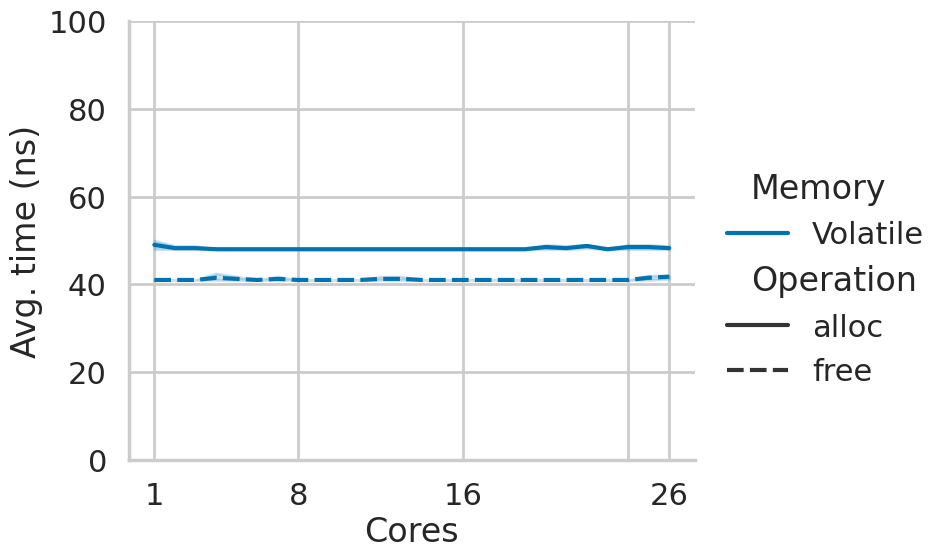

In [6]:
data_v = read_orders(volatile_c / "bulk", [0])
data_v["Memory"] = "Volatile"

data = data_v
data["bench"] = "Bulk"
pgd = data[["bench", "order", "cores", "Memory", "alloc", "free"]].melt(
    id_vars=["bench", "order", "cores", "Memory"],
    value_vars=["alloc", "free"], value_name="time", var_name="Operation")

with sns.plotting_context("poster"):
    g = sns.FacetGrid(data=pgd,
                      height=6, aspect=1.3, margin_titles=True)
    g.map_dataframe(sns.lineplot, x="cores", y="time",
                    style="Operation", hue="Memory")
    
    g.add_legend(adjust_subtitles=True)
    

    g.set(xticks=[1, 8, 16, 24, 26])
    for ax in g.axes_dict.values():
        ax.set_xticks(list(range(0, 27, 2)), minor=True)
        ax.grid(which="minor", alpha=0.3)
    g.set(xticklabels=[1, 8, 16, "", 26])

    g.set(ylim=(0, 100))
    # g.set(ylim=(1, 10**5 * 1.5))
    # g.set(yscale="log")
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Cores")
    g.set_titles(col_template="{col_name}", row_template="Order {row_name}")
    g.savefig("talk/llfree_cores_bulk_v.pdf")



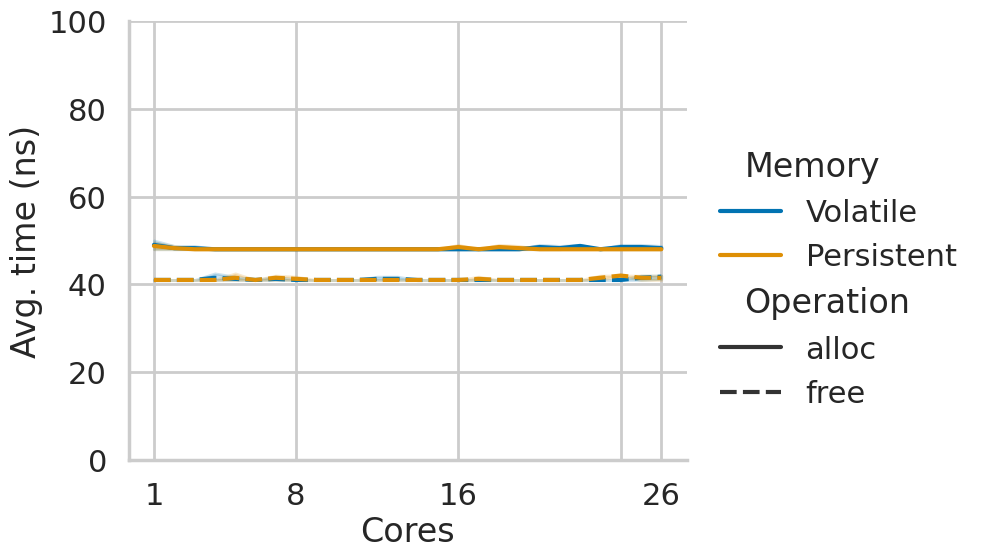

In [36]:
data_v = read_orders(volatile_c / "bulk", [0])
data_v["Memory"] = "Volatile"
data_p = read_orders(peristent_c / "bulk", [0])
data_p["Memory"] = "Persistent"

data = pd.concat([data_v, data_p])
data["bench"] = "Bulk"
pgd = data[["bench", "order", "cores", "Memory", "alloc", "free"]].melt(
    id_vars=["bench", "order", "cores", "Memory"],
    value_vars=["alloc", "free"], value_name="time", var_name="Operation")

with sns.plotting_context("poster"):
    g = sns.FacetGrid(data=pgd,
                      height=6, aspect=1.3, margin_titles=True)
    g.map_dataframe(sns.lineplot, x="cores", y="time",
                    style="Operation", hue="Memory")
    g.add_legend(adjust_subtitles=True)

    g.set(xticks=[1, 8, 16, 24, 26])
    for ax in g.axes_dict.values():
        ax.set_xticks(list(range(0, 27, 2)), minor=True)
        ax.grid(which="minor", alpha=0.3)
    g.set(xticklabels=[1, 8, 16, "", 26])

    g.set(ylim=(0, 100))
    # g.set(ylim=(1, 10**5 * 1.5))
    # g.set(yscale="log")
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Cores")
    g.set_titles(col_template="{col_name}", row_template="Order {row_name}")
    g.savefig("talk/llfree_cores_bulk.pdf")


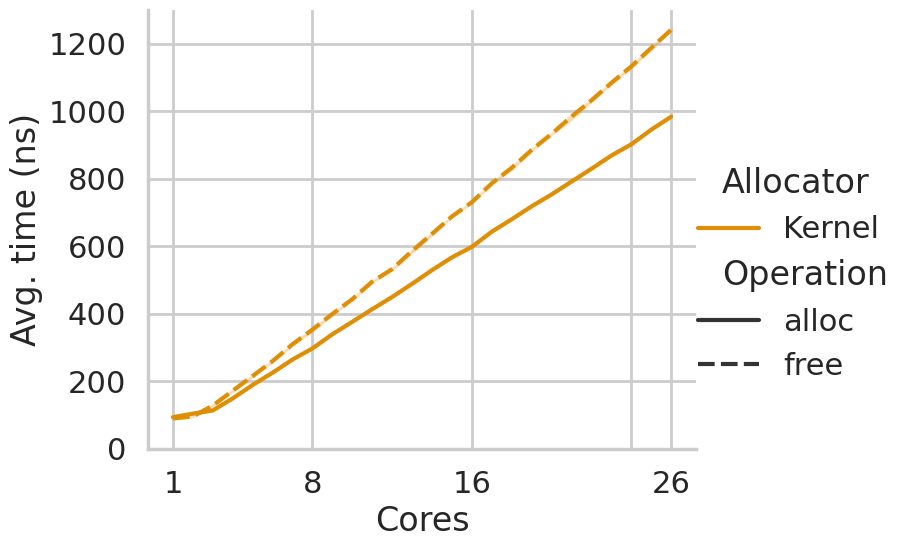

In [5]:
data_bu = read_orders(buddy_c / "bulk", [0])
data_bu["Allocator"] = "Kernel"

pgd = data_bu.melt(
    id_vars=["Allocator", "order", "cores"],
    value_vars=["alloc", "free"], value_name="time", var_name="Operation")

with sns.plotting_context("poster"):
    g = sns.FacetGrid(data=pgd, aspect=1.3,
                      height=6, sharey=False)
    g.map_dataframe(sns.lineplot, x="cores", y="time",
                    hue="Allocator", hue_order=[None, "Kernel"], style="Operation")

    g.add_legend(adjust_subtitles=True)
    # g.legend.set_title("Operation")

    g.set(xticks=[1, 8, 16, 24, 26])
    for ax in g.axes_dict.values():
        ax.set_xticks(list(range(0, 27, 2)), minor=True)
        ax.grid(which="minor", alpha=0.3)
    g.set(xticklabels=[1, 8, 16, "", 26])

    g.set(ylim=(0, None))
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Cores")
    g.set_titles("Order {col_name}")
    g.savefig("talk/kernel_bulk_linux.pdf")


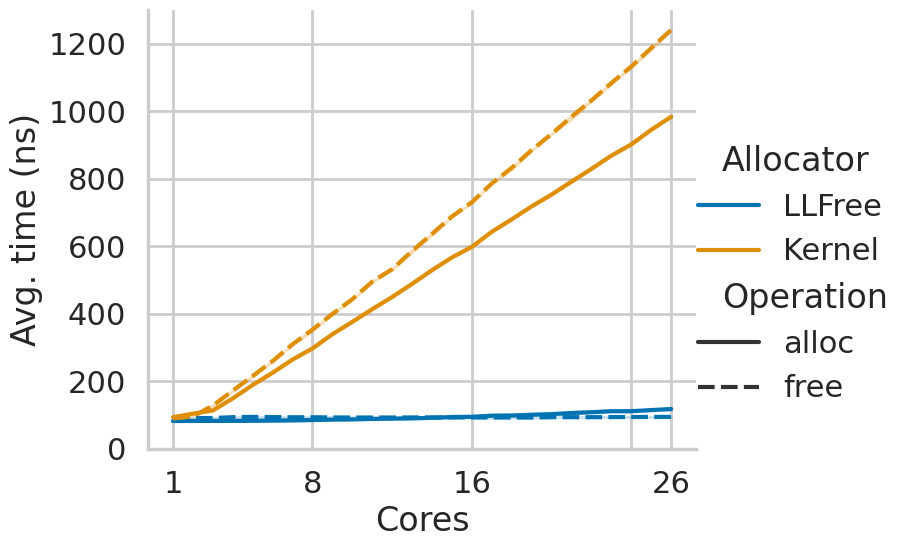

In [2]:
data_bu = read_orders(buddy_c / "bulk", [0])
data_bu["Allocator"] = "Kernel"
data_ll = read_orders(llfree_c / "bulk", [0])
data_ll["Allocator"] = "LLFree"

data = pd.concat([data_ll, data_bu])

pgd = data.melt(
    id_vars=["Allocator", "order", "cores"],
    value_vars=["alloc", "free"], value_name="time", var_name="Operation")

with sns.plotting_context("poster"):
    g = sns.FacetGrid(data=pgd, aspect=1.3,
                      height=6, sharey=False)
    g.map_dataframe(sns.lineplot, x="cores", y="time",
                    hue="Allocator", style="Operation")

    g.add_legend(adjust_subtitles=True)
    # g.legend.set_title("Operation")

    g.set(xticks=[1, 8, 16, 24, 26])
    for ax in g.axes_dict.values():
        ax.set_xticks(list(range(0, 27, 2)), minor=True)
        ax.grid(which="minor", alpha=0.3)
    g.set(xticklabels=[1, 8, 16, "", 26])

    g.set(ylim=(0, None))
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Cores")
    g.set_titles("Order {col_name}")
    g.savefig("talk/kernel_bulk.pdf")


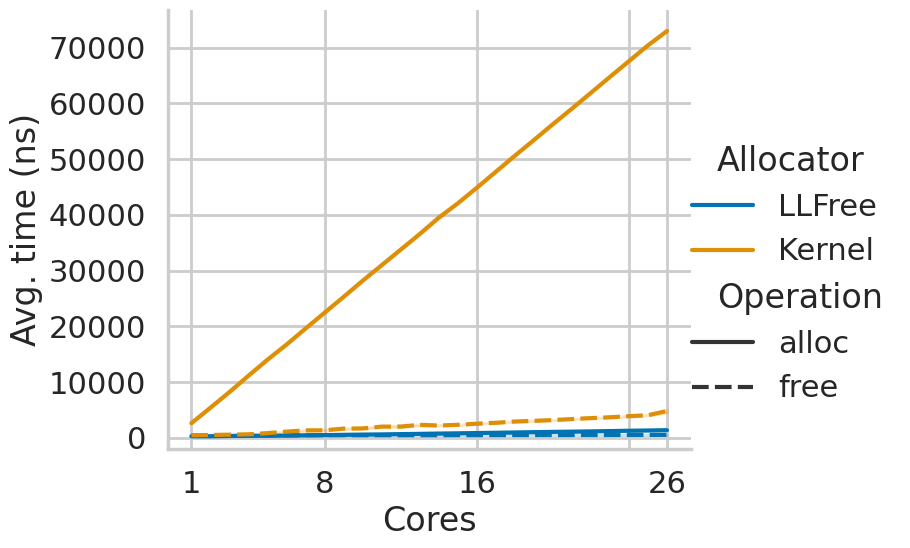

In [3]:
data_bu = read_orders(buddy_c / "bulk", [9])
data_bu["Allocator"] = "Kernel"
data_ll = read_orders(llfree_c / "bulk", [9])
data_ll["Allocator"] = "LLFree"

data = pd.concat([data_ll, data_bu])

pgd = data.melt(
    id_vars=["Allocator", "order", "cores"],
    value_vars=["alloc", "free"], value_name="time", var_name="Operation")

with sns.plotting_context("poster"):
    g = sns.FacetGrid(data=pgd, aspect=1.3,
                      height=6, sharey=False)
    g.map_dataframe(sns.lineplot, x="cores", y="time",
                    hue="Allocator", style="Operation")

    g.add_legend(adjust_subtitles=True)
    # g.legend.set_title("Operation")

    g.set(xticks=[1, 8, 16, 24, 26])
    for ax in g.axes_dict.values():
        ax.set_xticks(list(range(0, 27, 2)), minor=True)
        ax.grid(which="minor", alpha=0.3)
    g.set(xticklabels=[1, 8, 16, "", 26])

    g.set(ylim=(-2000, None))
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Cores")
    g.set_titles("Order {col_name}")
    g.savefig("talk/kernel_bulk_huge.pdf")
